## Project 4: West Nile Virus Prediction
---
## Part 1c. Spray data EDA & Cleaning
Group 2 (Edmund, Marc, Mingzi, Rohazeanti), SG DSIF5 

## Table of Contents
- [Importing the libraries](#Importing-the-libraries)
- [Importing the datasets](#Importing-the-datasets)
- [Merge Datasets](#Merge-Datasets)
- [Data Visualisations](#Data-Visualisations)

### Importing the libraries

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle

import datetime
from suntime import Sun, SunTimeException
from pytz import timezone
import pytz

import plotly.express as px
import calmap
import scipy.stats as stats

pd.set_option("display.max_columns", None)

### Importing the datasets

In [92]:
# Import train dataset from pickle file
train = pd.read_pickle('./data/train_final.pkl')
print(f'The training data has {train.shape[0]} rows and {train.shape[1]} columns')

# Import weather dataset from pickle file
weather = pd.read_pickle('./data/weather_final.pkl')
print(f'The weather data has {weather.shape[0]} rows and {weather.shape[1]} columns')

# Import weather dataset from pickle file
spray = pd.read_pickle('./data/spray_final.pkl')
print(f'The spray data has {spray.shape[0]} rows and {spray.shape[1]} columns')

The training data has 8610 rows and 13 columns
The weather data has 2920 rows and 23 columns
The spray data has 14835 rows and 8 columns


### Merge Datasets

In [93]:
# Drop Year, Month, Day, Week columns from weather dataset
weather.drop(['Year', 'Month', 'Day', 'Week'], axis=1, inplace=True)

In [94]:
# Merge Training and Weather dataset
train_weather = pd.merge(train, weather, on=['Date','Station'])
print(f'The training data has {train_weather.shape[0]} rows and {train_weather.shape[1]} columns')

The training data has 8578 rows and 30 columns


In [95]:
train_weather.isnull().sum()

Date            0
Species         0
Trap            0
Latitude        0
Longitude       0
WnvPresent      0
NumMosquitos    0
Year            0
Month           0
Day             0
Week            0
Station         0
LongLat         0
Tmax            0
Tmin            0
Tavg            0
DewPoint        0
WetBulb         0
Heat            0
Cool            0
WetDry          0
PrecipTotal     0
StnPressure     0
SeaLevel        0
ResultSpeed     0
ResultDir       0
AvgSpeed        0
SunHours        0
R_Humid         0
Trange          0
dtype: int64

### Data Visualisations

**Correlation Matrix**

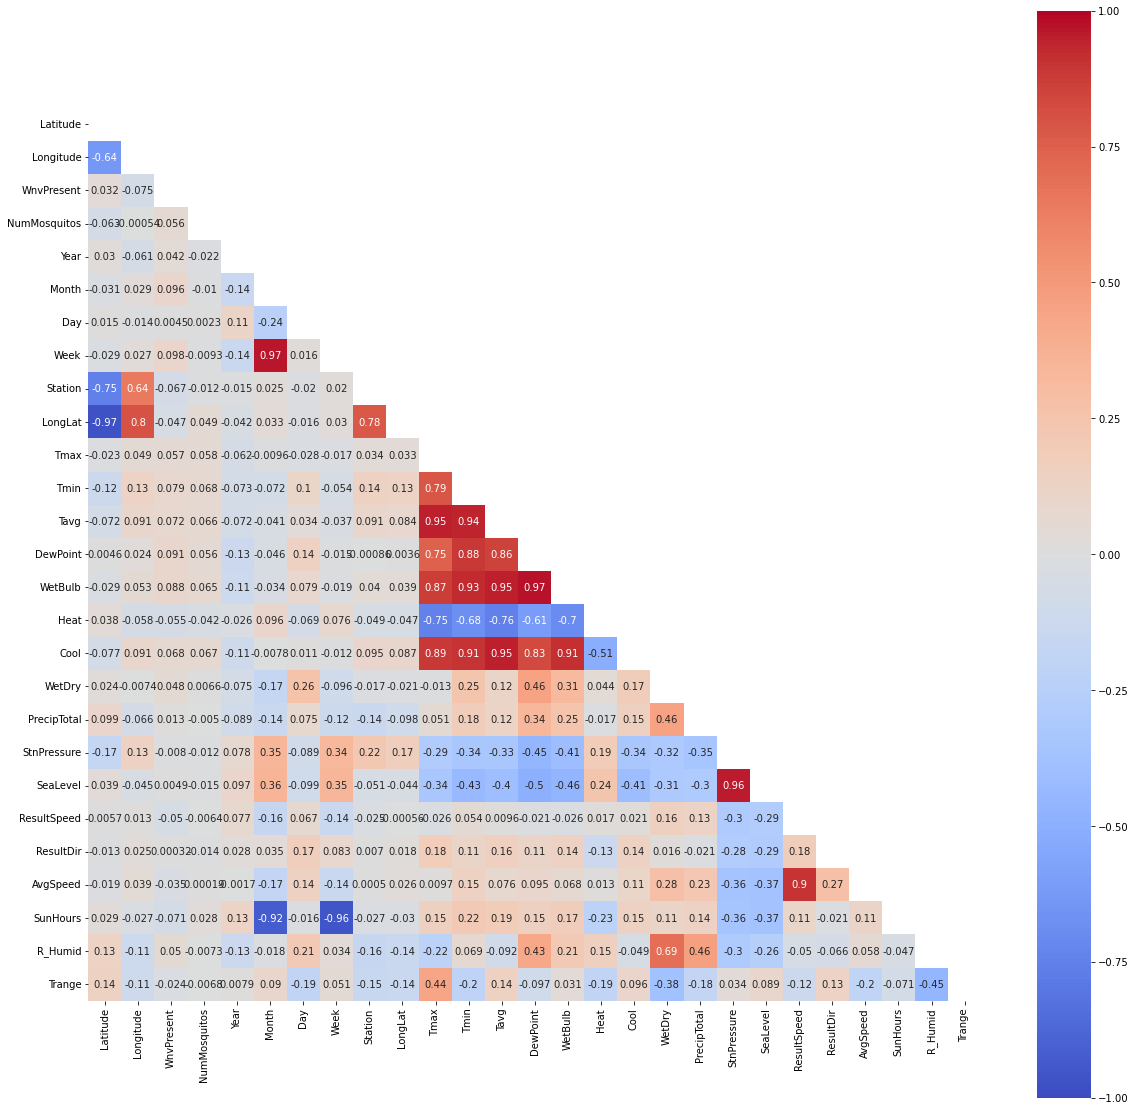

In [96]:
corr = train_weather.corr()

fig, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
sns.heatmap(data= corr,       
            mask= mask,
            cmap = 'coolwarm',
            square= True,          
            annot = True,
            vmin=-1, vmax=1);

- "SeaLevel" and "StnPressure" both measure the air pressure in the city of Chicago, and are both highly correlated.
- "ResultSpeed" and "AvgSpeed" both measure the windspeed in the city of Chicago, and are both highly correlated.
- The features "Tmin", "Tmax", "Tavg", "DewPoint", "WetBulb", "Heat" and "Cool" are all highly correlated with each other as they all refer to the same measurement of temperature.
- We will conduct VIF for these highly correlated features before deciding which ones to be dropped. 

**Presence of Mosquitos and WNV Presence based on location**

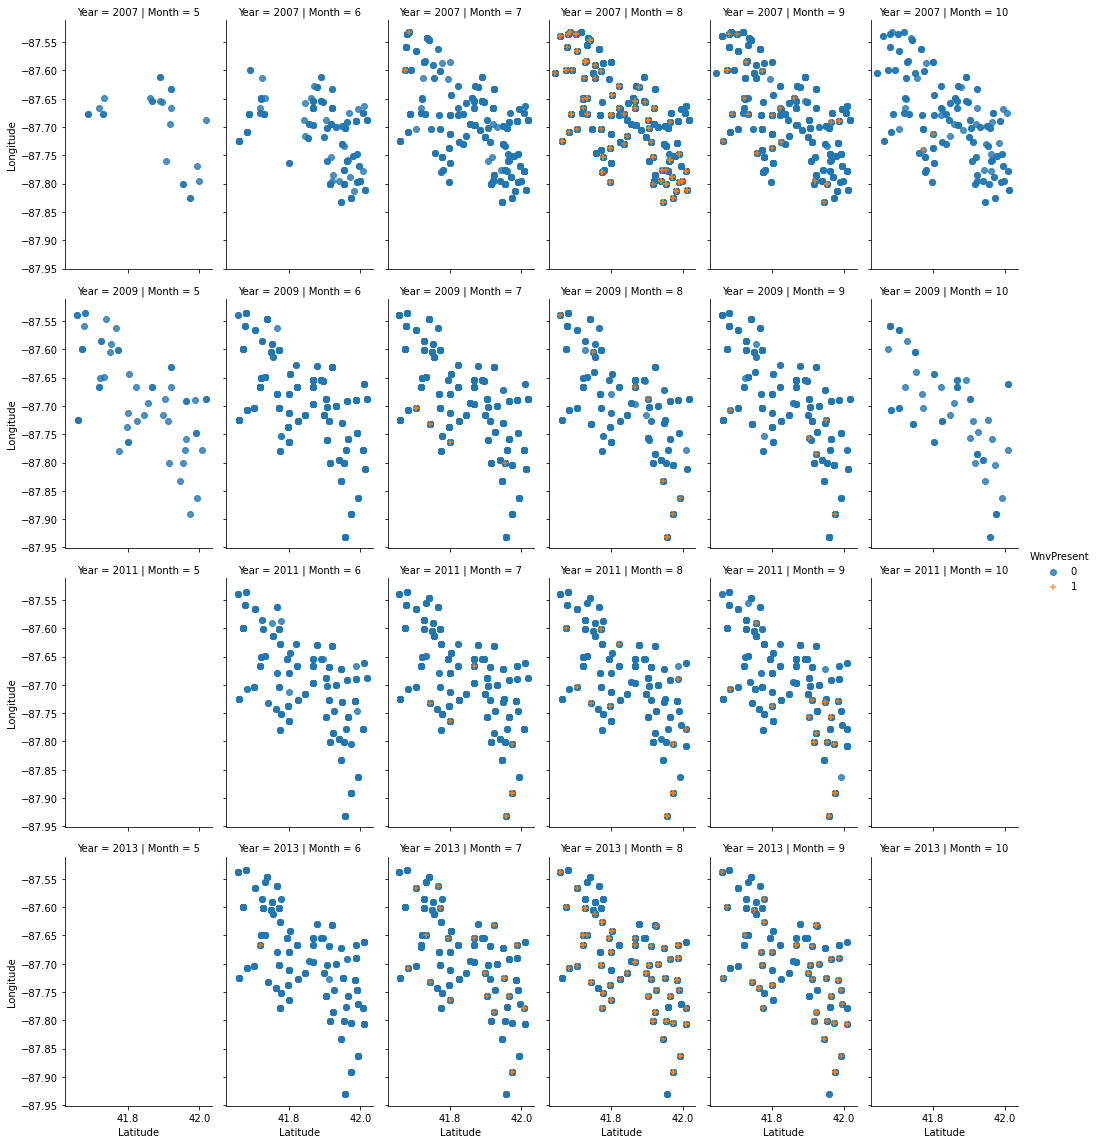

In [179]:
sns.lmplot(x="Latitude", y="Longitude",markers=['o','+'], hue="WnvPresent", col="Month",row="Year",
               data=train_weather, height=4, aspect=.6, fit_reg=False);

- It is clear that there are more WNV cases in Aug 2007 and Aug 2018 than the other months

In [287]:
def create_lineplot(col):
    plt.figure(figsize=(15, 3))
    color = 'tab:green'
    ax = sns.lineplot(x="Week", y = col, data=train_weather, marker='o', color=color)
    ax.set_ylabel(col, color=color)

    ax2 = ax.twinx()
    color = 'tab:red'
    #color2 = 'tab:blue'
    sns.lineplot(data=train_weather, x="Week", y="WnvPresent", color=color, estimator=sum, ax=ax2)
    #sns.lineplot(x="Week", y = "NumMosquitos", data=train_weather,estimator='mean', marker='o', color=color2)
    ax2.set_ylabel('WnvPresent', color=color)

    plt.show();

**How does Relative Humidity & Temperature Range affects WNV?**
- Presence of WNV increases with increase in Relative humidity, peaking about the same  between week 32.5 and 35. However, that is not the case when relative humidity increases and peaks at week 40. We also take into consideration that Humidity is not the only cause of presence of WNV, and there are other contributing. Furthermore, at week40, the summer season has ended and in several observations conducted, the WNV decreases as Summer ends. 
- Average Wind speed has somewhat inverse relationship with presence of WNV.   

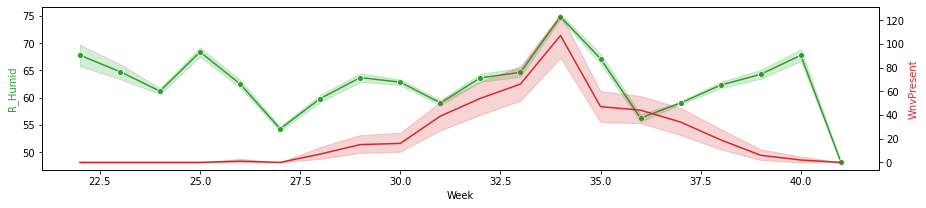

In [288]:
create_lineplot('R_Humid')

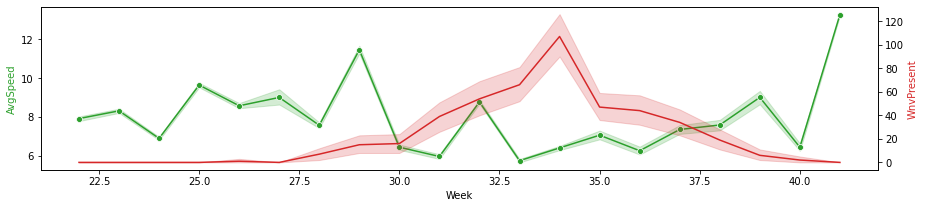

In [289]:
create_lineplot('AvgSpeed')

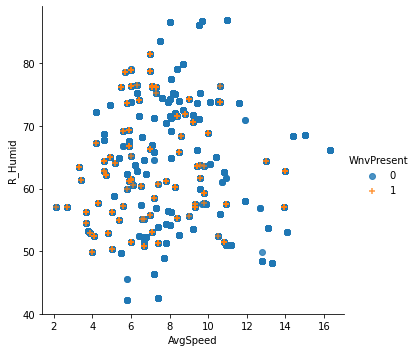

In [290]:
sns.lmplot(y='R_Humid',x='AvgSpeed',data=train_weather,hue='WnvPresent',markers=['o','+'],fit_reg=False);

**How does Average Temperature & Total Precipitation affects WNV?**
- Average Temperature between 70-75 seems to be the ideal temperature for the mosquitos to breed and incubate. As seen in the visualisation below that between week 27.5 to week 35, the temperature maintained between 70-75 and the period is long enough for mosquitos to breed and incubate. Hence, we see the number of WNV present increases between week 27-34 

- Precipitation does not immediately affects the presence of WNV or mosquito breeding. Drier days after heavy rainfalls, where there are puddles and stagnant water due to the rain, becomes a thriving ground for the mosquitos to breed and incubation of WNV. Hence, our visualisation below does not show the immediate effects of precipitation affecting Wnv and mosquito breeding.

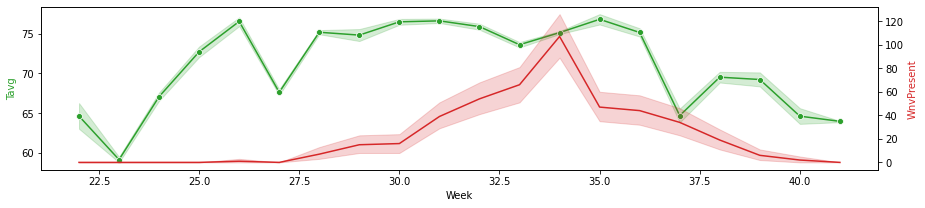

In [294]:
create_lineplot('Tavg')

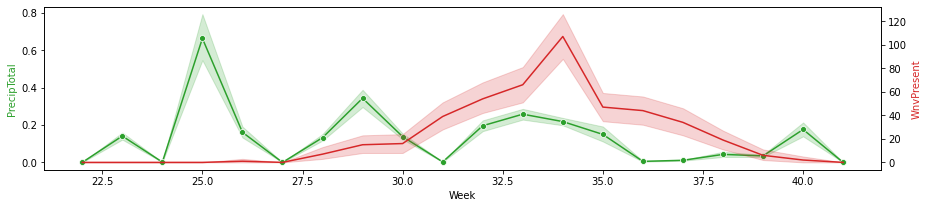

In [295]:
create_lineplot('PrecipTotal')

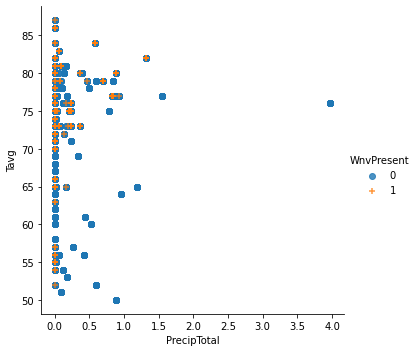

In [296]:
sns.lmplot(y='Tavg',x='PrecipTotal',data=train_weather,hue='WnvPresent',markers=['o','+'],fit_reg=False);

**How does DewPoint & WetBulb affects WNV?**
- WetBulb and Dewpoint has positive relationship with presence of WNV as well number of mosquitos

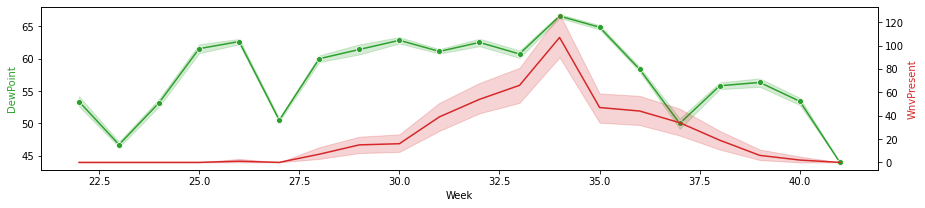

In [291]:
create_lineplot('DewPoint')

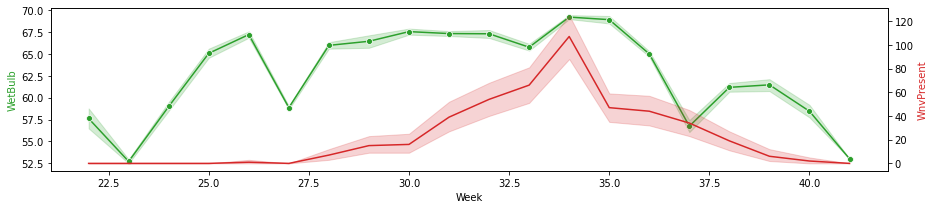

In [292]:
create_lineplot('WetBulb')

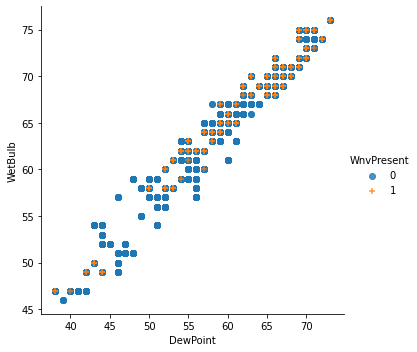

In [293]:
sns.lmplot(y='WetBulb',x='DewPoint',data=train_weather,hue='WnvPresent',markers=['o','+'],fit_reg=False);

**How amount of sun available in a day affects WNV**
- Prolonged amount of sun at ideal temperature allows for mosquito to breed

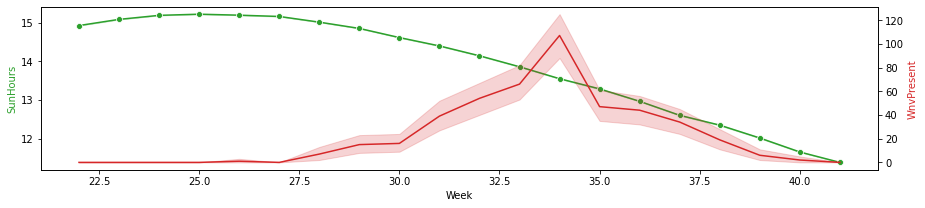

In [311]:
create_lineplot('SunHours')

**Effects of sprays**
- As we only have spray data of 2 years, 2011 and 2013, we look at when the spray had taken place for both years separately

In [297]:
spray['sprayed'] = 1

**Spray in year 2011**

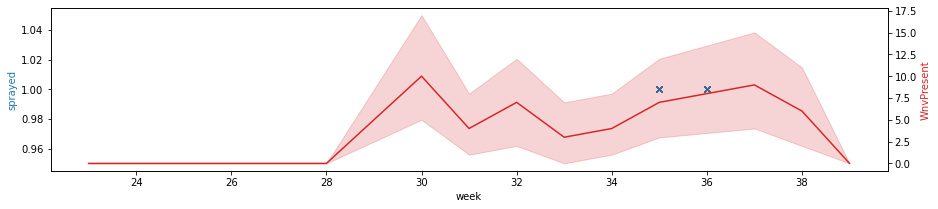

In [298]:
plt.figure(figsize=(15, 3))
color = 'tab:blue'
ax = sns.scatterplot(x="week", y = "sprayed", data=spray[spray.year == 2011], marker='x', color=color)
ax.set_ylabel('sprayed', color=color)

ax2 = ax.twinx()
color = 'tab:red'
sns.lineplot(data=train_weather[train_weather.Year == 2011], x="Week", y="WnvPresent", color=color, estimator=sum, ax=ax2)
ax2.set_ylabel('WnvPresent', color=color)

plt.show();

- Even though we see that there is a decrease in WNV presence after the spray, we have to take into consideration that the spray happened towards the end of summer, where weather conditions becomes unfavourable for mosquitos to thrive.

**Spray in 2013**

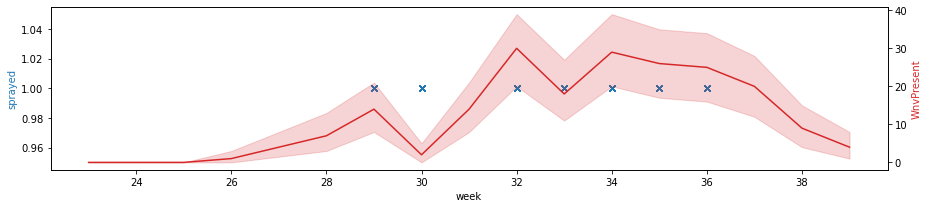

In [191]:
plt.figure(figsize=(15, 3))
color = 'tab:blue'
ax = sns.scatterplot(x="week", y = "sprayed", data=spray[spray.year == 2013], marker='x', color=color)
ax.set_ylabel('sprayed', color=color)

ax2 = ax.twinx()
color = 'tab:red'
sns.lineplot(data=train_weather[train_weather.Year == 2013], x="Week", y="WnvPresent", color=color, estimator=sum, ax=ax2)
ax2.set_ylabel('WnvPresent', color=color)

plt.show();

- More sprays took place in year 2013. But I am doubtful on the effectiveness of the sprays as the WNV continues to increase after the first two sprays. One possible reason is that it was not sprayed at the right location where WNV was thriving. 

Next, we will look at where the sprays took place to confirm our suspicion

In [196]:
train_weather_2013 = train_weather[train_weather.Year==2013]

C:\Users\rohaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



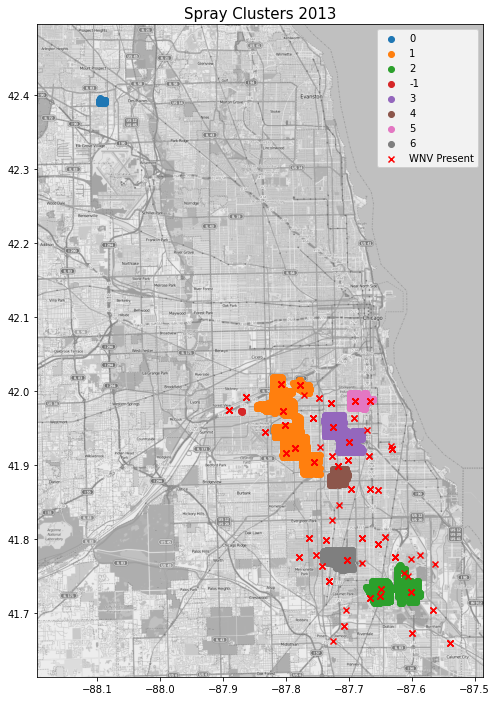

In [199]:
from sklearn.cluster import DBSCAN, KMeans
mapdata = np.loadtxt('mapdata_copyright_openstreetmap_contributors.txt/mapdata_copyright_openstreetmap_contributors.txt')  #use map data 

#use DBSCAN to cluster spray data to use to create spray cluster feature
X_spray = spray[['Latitude', 'Longitude']] #isolate lat long data
spray_cluster_model = DBSCAN(eps=.01, min_samples=20).fit(X_spray) #run DBSCAN (parameters set after multiple iterations)
X_spray['cluster'] = spray_cluster_model.labels_ #create cluster feature 

#set dimensions of plot
lon_lat_box_spray = (X_spray['Longitude'].min()-.1, X_spray['Longitude'].max()+.1, X_spray['Latitude'].min()-.1,X_spray['Latitude'].max()+.1)

#create plot of spray clusters, for loop allows for legend to represent clusters 
fig, ax = plt.subplots(figsize=(8,12))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box_spray) 

#iterate through each cluster value and plot points in the same figure (maintains lables)
for i in X_spray['cluster'].unique():  
    ax.scatter(X_spray[X_spray['cluster'] == i]['Longitude'], 
               X_spray[X_spray['cluster'] == i]['Latitude'], 
               label=i, marker='o')

#overlay WNV presence
plt.scatter(train_weather_2013[train_weather_2013['WnvPresent'] == 1]['Longitude'], 
            train_weather_2013[train_weather_2013['WnvPresent'] == 1]['Latitude'], 
            marker='x', label='WNV Present', color='r')


plt.legend()
plt.title('Spray Clusters 2013', size=15);

- From the visualisation above, we see that many areas where WNV is present were not sprayed. Hence, that explains why WNV kept increasing despite the sprays